# Percentages of flights belonging to a distance group that halved a delay

In this notebook we compute the percentage of flights belonging to a given "distance group" that were able to halve their departure delays by the time they arrived at their destinations. Distance groups assort flights by their total distance in miles. Flights with distances that are less than 200 miles belong in group 1, flights with distances that are between 200 and 399 miles belong in group 2, flights with distances that are between 400 and 599 miles belong in group 3, and so on. The last group contains flights whose distances are between 2400 and 2599 miles.


So basically:

- By the _Distance_ attribute we can infer the flight group:

\begin{equation}
FlightGroup = \left( Distance // 200 \right) + 1
\end{equation}

- For each flight we can say if it has halved or not its delay:


\begin{equation}
    DelayHalved=
    \begin{cases}
      yes, & \text{if}\ \left(DepDealy \neq 0\right) \quad \textrm{and} \quad \left(ArrDelay <= \frac{DepDealy}{2} \right)\\
      no, & \text{otherwise}
    \end{cases}
\end{equation}


- So, for each flight group we can create two sets of flight: those that have halved their delays and the others

### Assumptions

- The last group, as the assignment states, is group ( 2599 // 200 ) + 1 = 13
- Each flight not belonging to any group is not considered

#### Execution mode

If development mode is turned on, all the calculations will be performed on a reduced instance of the data set.

This allows to *save computation time* while developing.

In [1]:
### development mode
# False when performing real analytics
DEV = True

### threads to be used to run spark worker nodes locally
spark_local_threads = 6  

### max number of flights groups
max_flight_group = 13

#### Find and import Apache Spark on this machine

In [2]:
import findspark
findspark.init()

In [3]:
# imports
from copy import copy
from pprint import pprint
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import *

import matplotlib.pyplot as plt

import warnings; warnings.simplefilter('ignore')

#### Create a new session

In [4]:
# Build a Spark SQL Session for DataFrames
master = 'local[{}]'.format(spark_local_threads)
appName = 'Airport Distance Groups Percentages'
spark = SparkSession \
    .builder \
    .appName(appName) \
    .master(master) \
    .getOrCreate()

#### Load the data

Try to load the optimized *parquet* format data set. If *parquet* data set is not found, load full compressed data sets, reduce and save them.

In [5]:
from preprocessing_utils import *

if DEV:
    # DEV preprocessing
    perform_DEV_dataset_preprocessing(spark)
else:
    # Production preprocessing
    perform_dataset_preprocessing(spark)

--------- DEV mode ON ---------
Starting preprocessing of ../dataset/1994.csv.bz2
Preprocessing NOT performed.
Preprocessed dataset already exists: ../dataset/preprocessed_dataset_1994.parquet



In [6]:
# Load the parquet dataset

if DEV:
    # Load DEV dataset
    df = load_DEV_preprocessed_dataset(spark)
else:
    # Load production dataset
    df = load_preprocessed_dataset(spark)

--------- DEV mode ON ---------
Peprocessed dataset loaded.
../dataset/preprocessed_dataset_1994.parquet


In [7]:
# Explore the data
if DEV:
    df.printSchema()
    print(df.head(2))
    print(df.dtypes)

root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- DepTime: string (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- ArrTime: string (nullable = true)
 |-- CRSArrTime: integer (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- FlightNum: integer (nullable = true)
 |-- TailNum: string (nullable = true)
 |-- ActualElapsedTime: string (nullable = true)
 |-- CRSElapsedTime: integer (nullable = true)
 |-- AirTime: string (nullable = true)
 |-- ArrDelay: integer (nullable = true)
 |-- DepDelay: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: integer (nullable = true)
 |-- TaxiIn: string (nullable = true)
 |-- TaxiOut: string (nullable = true)
 |-- Cancelled: integer (nullable = true)
 |-- CancellationCode: string (nullable = true)
 |-- Diverted: integer (nullable = true)
 |-- 

## Data selection and cleaning

In [8]:
# Select useful attributes
df = df.select(df['ArrDelay'], df['DepDelay'], df['Distance'])

N_before = df.count() # 5180048
# Drop null. Or maybe no! Maybe we can have the percentage of flights with missing values.
df = df.dropna()
N_after = df.count() # 5180048

total_flights_before_drop=N_before
rows_dropped_due_to_null=N_before-N_after

print("# of rows \n\t BEFORE: {:,}\n\t  AFTER: {:,}\n\tDROPPED: {:,}".format(N_before, N_after, rows_dropped_due_to_null))

df.show(5)

# of rows 
	 BEFORE: 5,180,048
	  AFTER: 5,078,411
	DROPPED: 101,637
+--------+--------+--------+
|ArrDelay|DepDelay|Distance|
+--------+--------+--------+
|       0|       0|     487|
|      -2|       5|     487|
|      -4|       0|     487|
|      -3|       0|     487|
|      -5|       0|     487|
+--------+--------+--------+
only showing top 5 rows



## FlightGroup

#### Which is the maximum Distance?

In [9]:
if DEV and 0:
    max_row = df.rdd.max(key=lambda x: int(x["Distance"]))

    print(max_row) # Row(ArrDelay='-13', DepDelay='6', Distance='4502')

In [10]:
# df.dtypes

In [11]:
# Calculate group
df = df.withColumn("Group", F.floor(df.Distance / 200) + 1)

#df.show(100)
#df.show()

#### Cut out all the groups above the considered limit

All flights that were categorized in groups above 13, will be dropped.

In [12]:
N_before = df.count()
# cut out all the groups above the considered limit
df = df.filter(df.Group <= max_flight_group)
N_after = df.count()

rows_dropped_due_to_group_limit=N_before-N_after


print("# of rows \n\t BEFORE: {:,}\n\t  AFTER: {:,}\n\tDROPPED: {:,}".format(N_before, N_after, rows_dropped_due_to_group_limit))

# of rows 
	 BEFORE: 5,078,411
	  AFTER: 5,062,226
	DROPPED: 16,185


## Delay was halved or not?

In [13]:
def delay_halved(args):
    dep_delay, arr_delay = args[0], args[1]
    
    # case in which the flight was departed on time
    # it cannot happen that it is able to halve its delay. There's no delay!
    if dep_delay == 0:
        return 'no'
    
    if arr_delay <=  (dep_delay / 2):
        return 'yes'
    
    # delay was not halved: arr_delay > dep_delay / 2
    return 'no'

delay_halved = F.udf(delay_halved, StringType())

# Calculate if the delay was halved or not
df = df.withColumn("DelayHalved", delay_halved(F.array('DepDelay', 'ArrDelay')))

df.show()

+--------+--------+--------+-----+-----------+
|ArrDelay|DepDelay|Distance|Group|DelayHalved|
+--------+--------+--------+-----+-----------+
|       0|       0|     487|    3|         no|
|      -2|       5|     487|    3|        yes|
|      -4|       0|     487|    3|         no|
|      -3|       0|     487|    3|         no|
|      -5|       0|     487|    3|         no|
|      15|      24|     487|    3|         no|
|      -1|       0|     487|    3|         no|
|     -10|       0|     487|    3|         no|
|       5|       0|     487|    3|         no|
|       2|       3|     487|    3|         no|
|      13|      15|     487|    3|         no|
|       3|       7|     487|    3|        yes|
|       1|       5|     487|    3|        yes|
|      -5|       0|     487|    3|         no|
|      -2|       0|     487|    3|         no|
|      -3|       0|     487|    3|         no|
|     -10|       0|     487|    3|         no|
|       4|      15|     487|    3|        yes|
|       0|   

In [14]:
# calculate total number of flights per group 
df_total = df.withColumn("count", F.lit(1))
df_total = df_total.groupBy('Group')                      \
                .sum('count')                             \
                .withColumnRenamed('sum(count)', 'n_flights') \
                .orderBy('Group')

# data frame rows should be only 13 rows, feasible to retrieve a pandas.DataFrame
pdf_total = df_total.toPandas()

df_total.show(15)

+-----+---------+
|Group|n_flights|
+-----+---------+
|    1|   538011|
|    2|  1440749|
|    3|   921899|
|    4|   630599|
|    5|   534478|
|    6|   340723|
|    7|   148884|
|    8|   177767|
|    9|   124662|
|   10|    65710|
|   11|    42198|
|   12|    32557|
|   13|    63989|
+-----+---------+



In [15]:
# create count support column
df = df.withColumn("DelayHalvedCount", F.lit(1))

df_perc = df.groupBy('Group', 'DelayHalved')                                  \
            .sum('DelayHalvedCount')                                          \
            .withColumnRenamed('sum(DelayHalvedCount)', 'DelayHalvedCount')   \
            .orderBy('Group', 'DelayHalved')

# data frame rows should be only 13*2 rows, feasible to retrieve a pandas.DataFrame
pdf_perc = df_perc.toPandas()

df_perc.show(30)

+-----+-----------+----------------+
|Group|DelayHalved|DelayHalvedCount|
+-----+-----------+----------------+
|    1|         no|          338014|
|    1|        yes|          199997|
|    2|         no|          970216|
|    2|        yes|          470533|
|    3|         no|          576346|
|    3|        yes|          345553|
|    4|         no|          389029|
|    4|        yes|          241570|
|    5|         no|          322100|
|    5|        yes|          212378|
|    6|         no|          208610|
|    6|        yes|          132113|
|    7|         no|           91235|
|    7|        yes|           57649|
|    8|         no|          108068|
|    8|        yes|           69699|
|    9|         no|           72380|
|    9|        yes|           52282|
|   10|         no|           35101|
|   10|        yes|           30609|
|   11|         no|           24798|
|   11|        yes|           17400|
|   12|         no|           18589|
|   12|        yes|           13968|
|

In [16]:
perc_halved_delays = {}


# Check sum of yes and no for halved delay correspond to the total number of flights of the group
for i, row in pdf_total.iterrows():
    row_p_no = pdf_perc.iloc[i*2]     # row position no
    row_p_yes = pdf_perc.iloc[i*2+1]  # row position yes
    print("asserting: {} == {} + {}".format(row['n_flights'], row_p_no['DelayHalvedCount'], row_p_yes['DelayHalvedCount']))
    assert(row['n_flights'] == (row_p_no['DelayHalvedCount'] + row_p_yes['DelayHalvedCount']))
    perc_halved_delays[i+1] = {
        'total_n_flights': row['n_flights'],
        'halved_yes': row_p_yes['DelayHalvedCount'],
        'halved_no': row_p_no['DelayHalvedCount'],
        'perc_do_halved_delay': row_p_yes['DelayHalvedCount'] / row['n_flights']
    }

pprint(perc_halved_delays)

asserting: 538011 == 338014 + 199997
asserting: 1440749 == 970216 + 470533
asserting: 921899 == 576346 + 345553
asserting: 630599 == 389029 + 241570
asserting: 534478 == 322100 + 212378
asserting: 340723 == 208610 + 132113
asserting: 148884 == 91235 + 57649
asserting: 177767 == 108068 + 69699
asserting: 124662 == 72380 + 52282
asserting: 65710 == 35101 + 30609
asserting: 42198 == 24798 + 17400
asserting: 32557 == 18589 + 13968
asserting: 63989 == 37059 + 26930
{1: {'halved_no': 338014,
     'halved_yes': 199997,
     'perc_do_halved_delay': 0.3717340351777194,
     'total_n_flights': 538011},
 2: {'halved_no': 970216,
     'halved_yes': 470533,
     'perc_do_halved_delay': 0.3265891560570231,
     'total_n_flights': 1440749},
 3: {'halved_no': 576346,
     'halved_yes': 345553,
     'perc_do_halved_delay': 0.3748273943241071,
     'total_n_flights': 921899},
 4: {'halved_no': 389029,
     'halved_yes': 241570,
     'perc_do_halved_delay': 0.3830802142090298,
     'total_n_flights': 630

Data visualization functions:

In [20]:
from matplotlib.font_manager import FontProperties


# General parameters setup
plt.rcParams['figure.figsize'] = [7,7]
plt.rcParams['axes.titlesize'] = 22
#total_flights_before_drop
#rows_dropped_due_to_group_limit
#rows_dropped_due_to_null
    
    
def show_missing_pie_chart():
    global total_flights_before_drop, rows_dropped_due_to_null
    
    total_minus_missing=total_flights_before_drop-rows_dropped_due_to_null

    slices = [total_minus_missing, rows_dropped_due_to_null]
    labels = [
        'Valid data [{:,} records]'.format(slices[0]),
        'Dropped due to missing values [{:,} records]'.format(slices[1])
    ]

    fig, ax = plt.subplots();
    wedges, texts, autotexts = ax.pie( slices, labels=labels,
                                       colors=['#009900','#e60000'],
                                       autopct='%1.1f%%',
                                       startangle=90,
                                       textprops=dict(color="w", fontproperties=FontProperties(size=14)));
    ax.set_title("Missing values");

    ax.axis('equal');

    ax.legend(wedges, labels,
              loc="center left",
              fontsize=14,
              bbox_to_anchor=(1, 0, 0.5, 1))



def show_group_exceeding_pie_chart():
    global total_flights_before_drop, rows_dropped_due_to_null, rows_dropped_due_to_group_limit

    total_minus_missing=total_flights_before_drop-rows_dropped_due_to_null
    total_minus_missing_minus_groups=total_minus_missing-rows_dropped_due_to_group_limit


    slices = [total_minus_missing_minus_groups, rows_dropped_due_to_group_limit]
    labels = [
        'Data with valid group value [{:,} records]'.format(slices[0]),
        'Dropped due to group > 13 [{:,} records]'.format(slices[1])
    ]

    fig, ax = plt.subplots();
    wedges, texts, autotexts = ax.pie( slices, labels=labels,
                                       colors=['#009900','#990073'],
                                       autopct='%1.1f%%',
                                       startangle=90,
                                       textprops=dict(color="w", fontproperties=FontProperties(size=14)));
    ax.set_title("Group value exceeding 13");

    ax.axis('equal');

    ax.legend(wedges, labels,
              loc="center left",
              fontsize=14,
              bbox_to_anchor=(1, 0, 0.5, 1));
    
    


def show_dropped_summary_pie_chart():
    global total_flights_before_drop, rows_dropped_due_to_null, rows_dropped_due_to_group_limit

    total_minus_missing=total_flights_before_drop-rows_dropped_due_to_null
    total_minus_missing_minus_groups=total_minus_missing-rows_dropped_due_to_group_limit

    slices = [total_minus_missing_minus_groups, rows_dropped_due_to_null, rows_dropped_due_to_group_limit]
    labels = [
        'Orinal total data [{:,} records]'.format(total_flights_before_drop),
        'Dropped due to missing [{:,} records]'.format(slices[1]),
        'Dropped due to group > 13 [{:,} records]'.format(slices[2]),
        'Totally dropped [{:,} records]'.format(total_flights_before_drop-total_minus_missing_minus_groups),
        'Valid data [{:,} records]'.format(slices[0])
    ]


    radius=1.2
    size = 0.2


    fig, ax = plt.subplots()
    wedges, texts, autotexts = ax.pie(slices,
                                      colors=['#009900', '#e60000', '#990073'],
                                      radius=radius,
                                      autopct='%1.1f%%',
                                      pctdistance=radius,
                                      wedgeprops=dict(width=size, edgecolor='w'),
                                      textprops=dict(fontproperties=FontProperties(size=14)))

    #------------------------------------------
    # Weges hack: since the legends of the first pie
    # chart will be only of the slices passed, here 
    # below add a copy of the wedge ad first element
    # in the weges
    w_orig_data = copy(wedges[0])
    w_orig_data.set_color('#3385ff')

    w_totally_dropped = copy(wedges[0])
    w_totally_dropped.set_color('#ffffff')
    #rearrange order according to labels
    wedges = [w_orig_data, wedges[1], wedges[2], w_totally_dropped, wedges[0]]

    ax.legend(wedges,
              labels,
              loc="center left",
              fontsize=14,
              bbox_to_anchor=(1.2, 0, 0.5, 1))
    #------------------------------------------

    wedges, texts, autotexts = ax.pie([total_flights_before_drop],
                                      colors=['#3385ff'],
                                      radius=radius-size,
                                      autopct='',
                                      wedgeprops=dict(width=0.1, edgecolor='w'))

    ax.set(aspect="equal", title='Dropped values summary')


    plt.show()

# Data visualization

## Data exluded from visualization


### Missing values

The following chart show the percentage of dropped rows due to missing values.

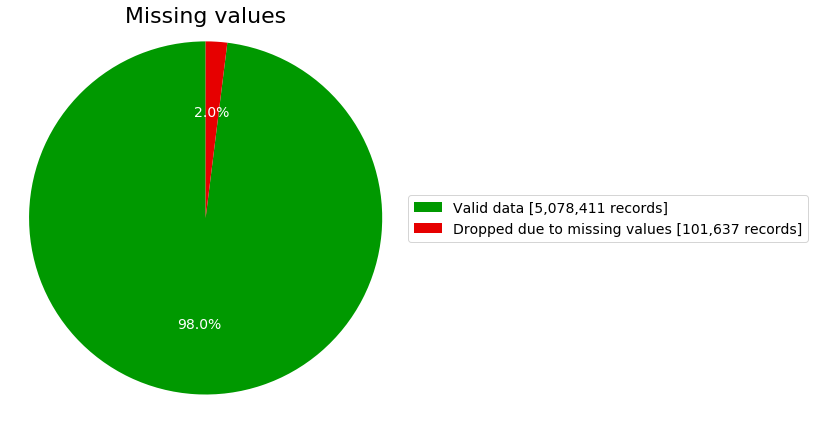

In [21]:
show_missing_pie_chart()

### Groups exceeding

The following chart show the percentage of dropped rows due to group value exceeding the last valid group (13).

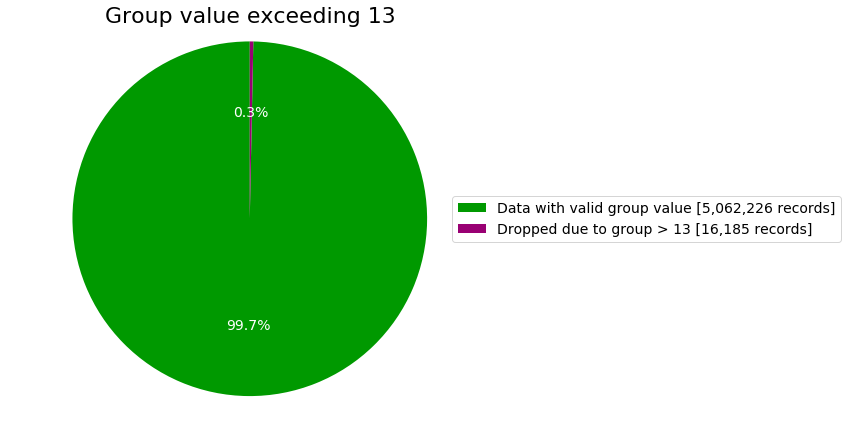

In [22]:
show_group_exceeding_pie_chart()

### Summary of dropped

The following chart show the summary of dropped rows

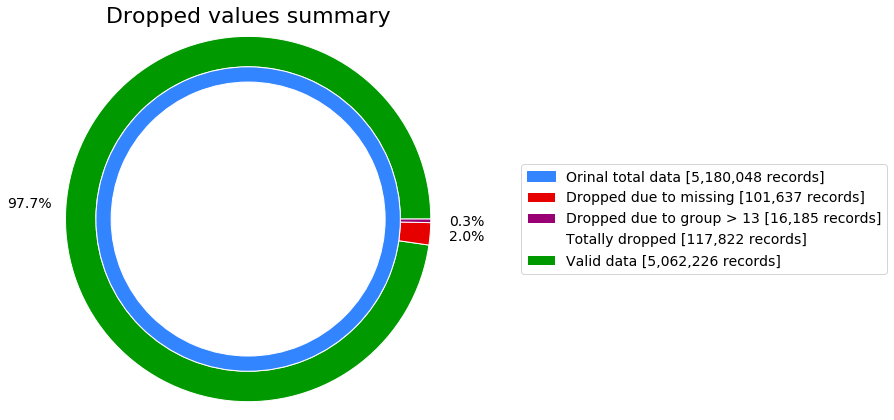

In [23]:
show_dropped_summary_pie_chart()